## Predicting Employee Attrition: A Human Resources Solution
### Leonid Shpaner, Payal Bhavesh Muni, and Sean Torres

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_score, recall_score, f1_score,\
accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from dmba import gainsChart
from prettytable import PrettyTable

import pydotplus
from IPython.display import Image
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

### Reading in and inspecting the dataframe

In [2]:
# read in the dataset from excel

url = 'https://raw.githubusercontent.com/munipayal1/\
MADS-505-Final-Project/main/HR_Employee_Data.csv'
hr = pd.read_csv(url)

In [3]:
# inspect the first 5 rows of the dataset
hr.head()

,Emp_Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,IND02438,38%,53%,2,157,3,0,1,0,sales,low
1,IND28133,80%,86%,5,262,6,0,1,0,sales,medium
2,IND07164,11%,88%,7,272,4,0,1,0,sales,medium
3,IND30478,72%,87%,5,223,5,0,1,0,sales,low
4,IND24003,37%,52%,2,159,3,0,1,0,sales,low


In [4]:
# removing percentage signs
hr['satisfaction_level'] = list(map(lambda x: x[:-1], 
                                    hr['satisfaction_level'].values))
#change satisfaction_level and last_evaluation to float
hr['satisfaction_level'] = (hr['satisfaction_level']).astype('float64')

hr['last_evaluation'] = list(map(lambda x: x[:-1], 
                                 hr['last_evaluation'].values))
# used .astype instead of numeric to alter df than series 
hr['last_evaluation'] = (hr['last_evaluation']).astype('float64')

hr.head()

,Emp_Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,IND02438,38.0,53.0,2,157,3,0,1,0,sales,low
1,IND28133,80.0,86.0,5,262,6,0,1,0,sales,medium
2,IND07164,11.0,88.0,7,272,4,0,1,0,sales,medium
3,IND30478,72.0,87.0,5,223,5,0,1,0,sales,low
4,IND24003,37.0,52.0,2,159,3,0,1,0,sales,low


In [5]:
# inspect # of rows and columns, unique values
numb_rows = hr.shape[0]
numb_col = hr.shape[1]
# check for unique employee ID number

print('Number of Rows:', numb_rows)
print('Number of Cols:', numb_col)
print('Numbver of unique rows:',hr['Emp_Id'].nunique())

Number of Rows: 14999
Number of Cols: 11
Numbver of unique rows: 14999


## Exploratory Data Analysis (EDA)

**Renaming Columns**

In [6]:
# Renaming some columns
hr = hr.rename(columns={'Emp_Id':'Employee_ID',
                        'average_montly_hours':
                        'average_monthly_hours',
                        'left':'Attrition'})
# Dummy Target Variable in a new column
hr['Status'] = hr['Attrition'].map({1:'left', 0:'stayed'})

In [7]:
print("\033[1m"+'Data Types'+"\033[1m")
hr.dtypes

Data Types


Employee_ID               object
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
time_spend_company         int64
Work_accident              int64
Attrition                  int64
promotion_last_5years      int64
Department                object
salary                    object
Status                    object
dtype: object

In [8]:
# inspect dataset for missing values
print("\033[1m"+'Null Value Counts'+"\033[1m")
hr.isnull().sum()

Null Value Counts


Employee_ID              0
satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
Attrition                0
promotion_last_5years    0
Department               0
salary                   0
Status                   0
dtype: int64

Employee Data: Correlation Matrix


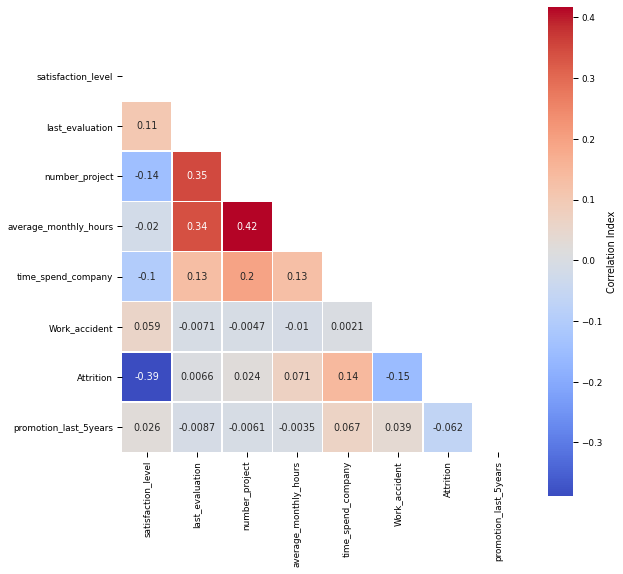

In [9]:
print("\033[1m"+'Employee Data: Correlation Matrix'+"\033[1m")
corr = hr.corr()
# sns.heatmap(corr, annot=True, mask=matrix)
sns.set_context('paper', font_scale=1)
plt.figure(figsize=(9,9))
plt.tight_layout(pad = 10, w_pad=10, h_pad=10)
matrix = np.triu(corr)
sns.heatmap(hr.corr(method='pearson'), annot=True, 
            linewidths=.5, cmap="coolwarm", mask=matrix,
            square = True, cbar_kws={'label': 'Correlation Index'})
plt.show()

**A moderate correlation of *r* = 0.42 exists between 'average_monthly_hours' and 'number_project.' 'Number_project' is less moderately correlated to 'last_evaluation' at *r* = 0.35. 'Average_monthly_hours' is slightly less moderately correlated to 'last_evaluation' at *r* = 0.34. 'Satisfaction_level' is also moderately correlated with the target 'Attrition' with a correlation coefficient *r* = -0.39.**
    
**From this analysis and the ensuing scatter plots below, it can be said that there exists a negative relationship between employee satisfaction and attrition. There exist almost no relationships between attrition and  other predictors, except 'time_spend_company', where *r* = 0.14, and 'work_accident', where *r* = -0.15.**

Selected Scatter Plots from Four Highest Correlated Predictors


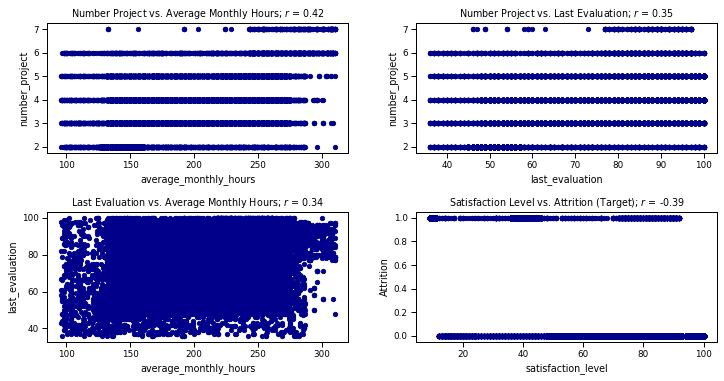

In [10]:
print("\033[1m"+'Selected Scatter Plots from \
Four Highest Correlated Predictors'+"\033[1m")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
flat = axes.flatten()
fig.tight_layout(w_pad=4, h_pad=4)
hr.plot.scatter(x='average_monthly_hours',
                y='number_project',
                c='DarkBlue',
                ax=flat[0])
corr1 = round(np.corrcoef(hr.average_monthly_hours,
                                hr.number_project)[0,1],2)
flat[0].set_title('Number Project vs. Average Monthly Hours;'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr1))

hr.plot.scatter(x='last_evaluation',
                y='number_project',
                c='DarkBlue',
                ax=flat[1])
corr2 = round(np.corrcoef(hr.last_evaluation,
                                hr.number_project)[0,1],2)
flat[1].set_title('Number Project vs. Last Evaluation;'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr2))
hr.plot.scatter(x='average_monthly_hours',
                y='last_evaluation',
                c='DarkBlue',
                ax=flat[2])
corr3 = round(np.corrcoef(hr.average_monthly_hours,
                                hr.last_evaluation)[0,1],2)
flat[2].set_title('Last Evaluation vs. Average Monthly Hours;'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr3))
hr.plot.scatter(x='satisfaction_level',
                y='Attrition',
                c='DarkBlue',
                ax=flat[3])
corr4 = round(np.corrcoef(hr.satisfaction_level,
                                hr.Attrition)[0,1],2)
flat[3].set_title('Satisfaction Level vs. Attrition (Target);'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr4))
plt.show()

In [11]:
print("\033[1m"+'Employee Summary Statistics'+"\033[1m")

def summary_by_var():
    pd.options.display.float_format = '{:,.2f}'.format
    summary = hr.describe().loc[['mean', 'std', 'min', 
                                      '25%', '50%', '75%', 'max']].T
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = summary.rename(columns = column_rename)
    return dfsummary

summary_by_var()

Employee Summary Statistics


,Mean,Standard Deviation,Minimum,25%,50%,75%,Maximum
satisfaction_level,61.28,24.86,9.00,44.00,64.00,82.00,100.00
last_evaluation,71.61,17.12,36.00,56.00,72.00,87.00,100.00
number_project,3.80,1.23,2.00,3.00,4.00,5.00,7.00
average_monthly_hours,201.05,49.94,96.00,156.00,200.00,245.00,310.00
time_spend_company,3.50,1.46,2.00,3.00,3.00,4.00,10.00
Work_accident,0.14,0.35,0.00,0.00,0.00,0.00,1.00
Attrition,0.24,0.43,0.00,0.00,0.00,0.00,1.00
promotion_last_5years,0.02,0.14,0.00,0.00,0.00,0.00,1.00


In [12]:
print("\033[1m"+'Average Monthly Hours: \
Summary Statistics by Department'+"\033[1m")

def summary_by_job():
    pd.options.display.float_format = '{:,.2f}'.format
    new = hr.groupby('Department')['average_monthly_hours']\
    .agg(["mean", "median", "std", "min", "max"])
    new.loc['Total'] = new.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = new.rename(columns = column_rename)
    new
    return dfsummary

summary_by_job()

Average Monthly Hours: Summary Statistics by Department


,Mean,Median,Standard Deviation,Minimum,Maximum
Department,,,,,
IT,202.22,199.00,50.69,96.00,308.00
RandD,200.80,200.00,49.25,98.00,308.00
accounting,201.16,199.00,51.11,97.00,310.00
hr,198.68,197.00,50.37,98.00,310.00
management,201.25,204.00,47.38,97.00,307.00
marketing,199.39,198.00,49.36,96.00,310.00
product_mng,199.97,198.00,50.11,98.00,310.00
sales,200.91,201.00,49.56,96.00,310.00
support,200.76,200.00,50.02,96.00,310.00


In [13]:
print("\033[1m"+'Satisfaction by Department: \
Summary Statistics'+"\033[1m")

def satisfaction_by_job():
    pd.options.display.float_format = '{:,.2f}'.format
    new2 = hr.groupby('Department')['satisfaction_level']\
    .agg(["mean", "median", "std", "min", "max"])
    new2.loc['Total'] = new2.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = new2.rename(columns = column_rename)
    new2
    return dfsummary
satisfaction_by_job()

Satisfaction by Department: Summary Statistics


,Mean,Median,Standard Deviation,Minimum,Maximum
Department,,,,,
IT,61.81,66.00,24.99,9.00,100.00
RandD,61.98,65.00,24.53,9.00,100.00
accounting,58.22,61.00,25.52,9.00,100.00
hr,59.88,61.00,24.79,9.00,100.00
management,62.13,65.50,22.77,9.00,100.00
marketing,61.86,64.00,24.43,9.00,100.00
product_mng,61.96,64.00,24.23,9.00,100.00
sales,61.44,64.00,25.03,9.00,100.00
support,61.83,65.00,24.64,9.00,100.00


In [14]:
print("\033[1m"+'Attrition Outcome by Department'+"\033[1m")

def ret_by_dept():
    dept_ret_stayed = hr.loc[hr.Status == 'stayed'].groupby\
    (['Department'])[['Status']].count()
    dept_ret_stayed.rename(columns={'Status':'Stayed'}, inplace=True)
    dept_ret_left = hr.loc[hr.Status == 'left'].groupby\
    (['Department'])[['Status']].count()
    dept_ret_left.rename(columns={'Status':'Left'}, inplace=True)
    merged_df = pd.concat([dept_ret_stayed, dept_ret_left], axis = 1)
    merged_df.loc['Total'] = merged_df.sum(numeric_only=True, axis=0)
    merged_df['# of Employees'] = merged_df.sum(axis=1)
    merged_df['% Retention'] = round((merged_df['Stayed'] / \
    (merged_df['Stayed'] + merged_df['Left']))* 100, 2)
    return merged_df.style.format("{:,.0f}")

ret_by_dept()

Attrition Outcome by Department


,Stayed,Left,# of Employees,% Retention
Department,,,,
IT,954,273,"1,227",78
RandD,666,121,787,85
accounting,563,204,767,73
hr,524,215,739,71
management,539,91,630,86
marketing,655,203,858,76
product_mng,704,198,902,78
sales,"3,126","1,014","4,140",76
support,"1,674",555,"2,229",75


**The ensuing bar graphs measure interdepartmental attrition. For example, sales has the highest attrition (employees who left), but also the highest retention (those who stayed). Normalizing this dsitribution, we see an uptick in hr department attrition in terms of rate, but a higher retention rate too. Sales, support, and technical departments remain at about equal attrition rates, and high retention across the board.**

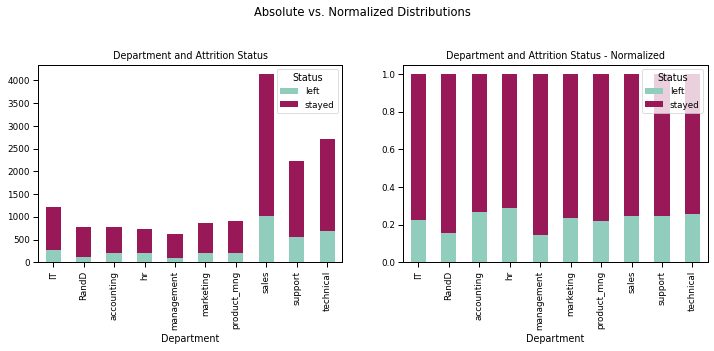

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
fig.suptitle('Absolute vs. Normalized Distributions')

crosstabdept = pd.crosstab(hr['Department'],hr['Status'])
crosstabdeptnorm = crosstabdept.div(crosstabdept.sum(1), axis = 0)

plotdest = crosstabdept.plot(kind='bar', stacked = True, 
                            title = 'Department and Attrition Status', 
                            ax = ax1, color = ['#90CDBC', '#991857'])

plotdeptnorm = crosstabdeptnorm.plot(kind='bar', stacked = True, 
                                     title = 'Department and'
                                     ' Attrition Status - Normalized', 
                                     ax = ax2, color = ['#90CDBC', 
                                                        '#991857'])

**The ensuing bar graphs measure attrition by salary. For example, there exists a higher prevalance in lower salaries than medium and higher salaries, respectively. Among the lower salaries, more employees stayed within the company than those who left. Normalizing the distribution, we see the same trends; however, in terms of attrition rates, the lowest among the three categories is evident in the higher salaries. Lower salaries show the highest attrition rate, and medium salaries follow.**

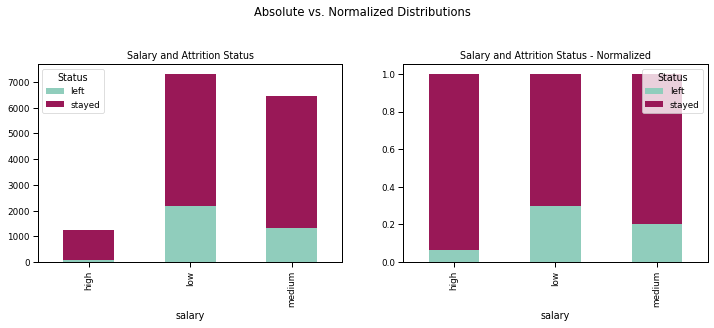

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
fig.suptitle('Absolute vs. Normalized Distributions')

crosstabsal = pd.crosstab(hr['salary'],hr['Status'])
crosstabsalnorm = crosstabsal.div(crosstabsal.sum(1), axis = 0)

plotdest = crosstabsal.plot(kind='bar', stacked = True, 
                            title = 'Salary and Attrition Status', 
                            ax = ax1, color = ['#90CDBC', '#991857'])

plotsalnorm = crosstabsalnorm.plot(kind='bar', stacked = True, 
                                     title = 'Salary and Attrition' 
                                     ' Status - Normalized', 
                                     ax = ax2, color = ['#90CDBC', 
                                                        '#991857'])

Boxplot Distributions


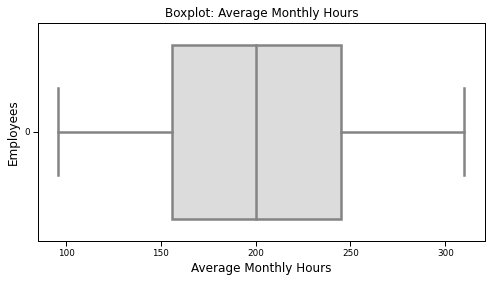

The first quartile is 156.0. 
The third quartile is 245.0. 
The IQR is 89.0.
The mean is 201.05.
The standard deviation is 49.94.
The median is 200.0.


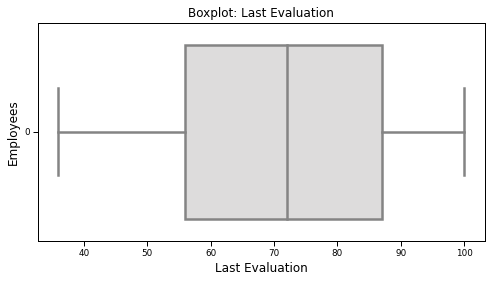

The first quartile is 56.0. 
The third quartile is 87.0. 
The IQR is 31.0.
The mean is 71.61.
The standard deviation is 17.12.
The median is 72.0.


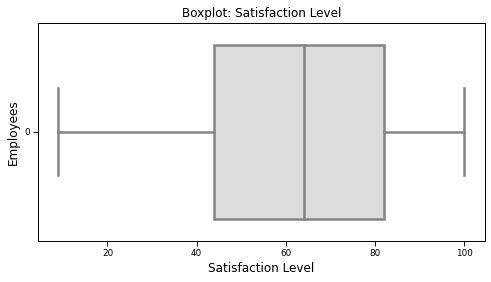

The first quartile is 44.0. 
The third quartile is 82.0. 
The IQR is 38.0.
The mean is 61.28.
The standard deviation is 24.86.
The median is 64.0.


In [17]:
print("\033[1m"+'Boxplot Distributions'+"\033[1m")
# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (8,4))
plt.title ('Boxplot: Average Monthly Hours',
          fontsize=12)
plt.xlabel('Average Monthly Hours', fontsize=12)
plt.ylabel('Employees', fontsize=12)

sns.boxplot(data=hr['average_monthly_hours'], 
            palette="coolwarm", orient='h', linewidth=2.5)
plt.show()

# Computing IQR
Q1 = hr['average_monthly_hours'].quantile(0.25)
Q3 = hr['average_monthly_hours'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['average_monthly_hours'].mean(),2)
std_1 = round(hr['average_monthly_hours'].std(),2)
median_1 = round(hr['average_monthly_hours'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)

# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (8,4))
plt.title ('Boxplot: Last Evaluation',
          fontsize=12)
plt.xlabel('Last Evaluation', fontsize=12)
plt.ylabel('Employees', fontsize=12)

sns.boxplot(data=hr['last_evaluation'], 
            palette="coolwarm", orient='h', linewidth=2.5)
plt.show()

# Computing IQR
Q1 = hr['last_evaluation'].quantile(0.25)
Q3 = hr['last_evaluation'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['last_evaluation'].mean(),2)
std_1 = round(hr['last_evaluation'].std(),2)
median_1 = round(hr['last_evaluation'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)

# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (8,4))
plt.title ('Boxplot: Satisfaction Level',
          fontsize=12)
plt.xlabel('Satisfaction Level', fontsize=12)
plt.ylabel('Employees', fontsize=12)

sns.boxplot(data=hr['satisfaction_level'], 
            palette="coolwarm", orient='h', linewidth=2.5)
plt.show()

# Computing IQR
Q1 = hr['satisfaction_level'].quantile(0.25)
Q3 = hr['satisfaction_level'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['satisfaction_level'].mean(),2)
std_1 = round(hr['satisfaction_level'].std(),2)
median_1 = round(hr['satisfaction_level'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)


**All of the examined boxplot distributions are normal.**

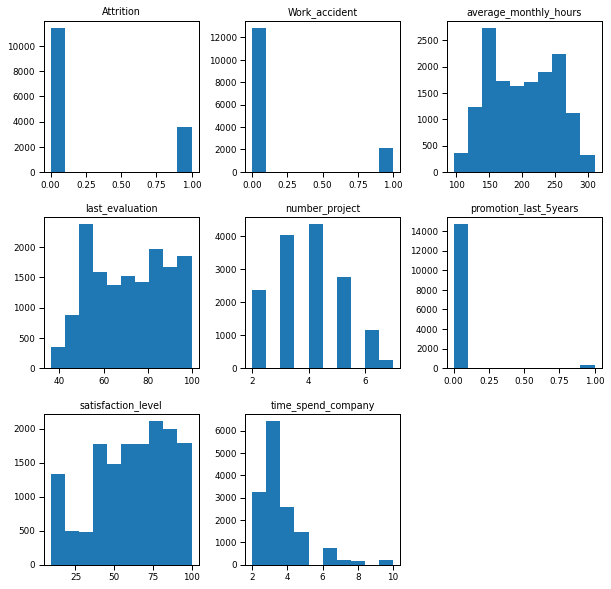

In [18]:
# checking for degenerate distributions
hr.hist(grid=False, figsize=(10,10))
plt.show()

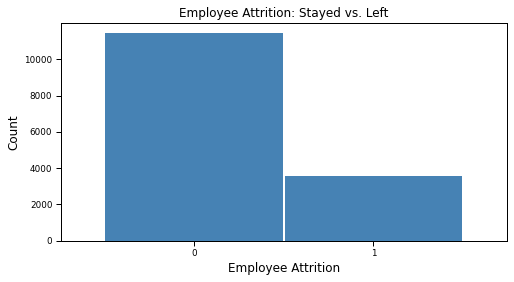

# of Employees that Stayed: 11428
# of Employees that Left: 3571
Attrition: 0.24


In [19]:
attrition_count = hr['Attrition'].value_counts()
fig = plt.figure(figsize=(8,4))
attrition_count.plot.bar(x ='lab', y='val', rot=0, width=0.99, 
                         color="steelblue")
plt.title ('Employee Attrition: Stayed vs. Left', fontsize=12)
plt.xlabel('Employee Attrition', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()

attrition_yes = attrition_count[1]
attrition_no = attrition_count[0]
attrition_rate = attrition_yes/(attrition_no + attrition_yes)

print('# of Employees that Stayed:', attrition_no)
print('# of Employees that Left:', attrition_yes)
print('Attrition:', round(attrition_rate,2))

## Pre-Processing

In [20]:
le_department = LabelEncoder()
hr['department_label'] = le_department.fit_transform(hr['Department'])

In [21]:
hr['satisfaction_level'] = .01*hr['satisfaction_level']
hr['last_evaluation'] = .01*hr['last_evaluation']

In [22]:
hr['salary_level'] = hr['salary'].map({'low':1,
                                       'medium':2, 
                                       'high':3})
# drop unnecessary columns
hr=hr.drop(columns=['Employee_ID','salary','Status', 'Department'])

**Generalized Linear Model - Logistic Regression Baseline**

$$y = \beta_0 + \beta_1x_1 +\beta_2x_2 +\cdots+\beta_px_p + \varepsilon$$

**Logistic Regression - Parametric Form**

$$p(y) = \frac{\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}{1+\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}  + \varepsilon$$

**Logistic Regression - Descriptive Form**

$$\hat{p}(y) = \frac{\text{exp}(b_0+b_1x_1+b_2x_2+\cdot\cdot\cdot+b_px_p)}{1+\text{exp}(b_0+b_1x_1+b_2x_2+\cdot\cdot\cdot+b_px_p)}$$

In [23]:
X = hr.drop(columns=['Attrition'])
X = sm.add_constant(X)
y = pd.DataFrame(hr[['Attrition']])
log_results = sm.Logit(y,X, random_state=42).fit()
log_results.summary()

Optimization terminated successfully.
         Current function value: 0.431309
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                14999
Model:                          Logit   Df Residuals:                    14989
Method:                           MLE   Df Model:                            9
Date:                Thu, 14 Oct 2021   Pseudo R-squ.:                  0.2142
Time:                        20:29:54   Log-Likelihood:                -6469.2
converged:                       True   LL-Null:                       -8232.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.0201      0.138      7.407      0.000       0.750       1.290
satisfaction_level       -4.1307      0.098    -42.303      0.000      -4.322      -3.939
last_evaluation           0.7265      0.148      4.893      0.000       0.435       1.017
number_project           -0.3124      0.021    -14.755      0.000      -0.354      -0.271
average_monthly_hours     0.0044      0.001      8.663      0.000       0.003       0.005
time_spend_company        0.2576      0.015     16.877      0.000       0.228       0.287
Work_accident            -1.5384      0.089    -17.193      0.000      -1.714      -1.363
promotion_last_5years    -1.5032      0.256     -5.862      0.000      -2.006      -1.001
department_label          0.0303      0.008      3.904      0.000       0.015       0.046
salary_level             -0.6992      0.038    -18.471      0.000      -0.773      -0.625
=========================================================================================
"""

All of the independent variables are statisticall significant at the $\alpha$ = 0.05 level.

## Train_Test_Validation Split

In [24]:
size_train = round(10499/14999,2)
size_valid = round(2250/14999,2)
size_test = round(300/2000,2)
print('training size:', size_train)
print('validation size:', size_valid)
print('test size:', size_test)

training size: 0.7
validation size: 0.15
test size: 0.15


In [25]:
train, test = train_test_split(hr, train_size = 10499, 
                               random_state = 42)
valid, test = train_test_split(test, train_size = 2250, 
                               random_state = 42)
# confirm dimensions (size of newly partioned data)
print('Training:',len(train))
print('Validation:', len(valid))
print('Test:', len(test))

Training: 10499
Validation: 2250
Test: 2250


In [26]:
X_var = list(hr.columns)
target ='Attrition'
X_var.remove(target)
X_train = train[X_var]
y_train = train[target]
X_test = test[X_var] 
y_test = test[target]
X_valid = valid[X_var]
y_valid = valid[target]

## Modeling

### Logistic Regression 

The initial Logistic Regression model is partially tuned, setting *C=1e42* to avoid regularization. The model is subsequently tuned over a regularization of *'l2'* norm, a liblinear solver because it "converges rapidly" (Galarnyk, 2021), and a set of varying cost parameters. Model accuracy and *f1*-score is improved. Details pertaining to these performance metrics are discussed in greater detail upon completion.

In [27]:
# Semi-tuned Logistic Regression
logit_reg = LogisticRegression(C=1e42, random_state=42) 
logit_reg.fit(X_train, y_train)

# Predict on validation set
logit_reg_pred1 = logit_reg.predict(X_valid)
# Predict on test set
logit_reg_pred2 = logit_reg.predict(X_test)

# accuracy and classification report
print('Untuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_valid, logit_reg_pred1))
print('Classification Report \n', 
       classification_report(y_valid, logit_reg_pred1))

C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRvalidAcc = []
LRtestAcc = []

# Tuned Logistic Regression Model
for param in C:
    tlr = LogisticRegression(penalty ='l2', 
                             solver = 'liblinear',
                             C=param, random_state=42)
    tlr.fit(X_train, y_train)

    tlr_pred_train = tlr.predict(X_train)
    # Predict on validation set
    tlr_pred_valid = tlr.predict(X_valid)
    # Predict on test set
    tlr_pred_test = tlr.predict(X_test)
    LRtrainAcc.append(accuracy_score(y_train, tlr_pred_train))
    LRvalidAcc.append(accuracy_score(y_valid, tlr_pred_valid))
    LRtestAcc.append(accuracy_score(y_test, tlr_pred_test))

# accuracy and classification report
print('Tuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_valid, tlr_pred_valid))
print('Classification Report \n', 
       classification_report(y_valid, tlr_pred_valid))

Untuned Logistic Regression Model
Accuracy Score
0.7795555555555556
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      1716
           1       0.56      0.32      0.41       534

    accuracy                           0.78      2250
   macro avg       0.69      0.62      0.63      2250
weighted avg       0.75      0.78      0.76      2250

Tuned Logistic Regression Model
Accuracy Score
0.7835555555555556
Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1716
           1       0.58      0.34      0.42       534

    accuracy                           0.78      2250
   macro avg       0.70      0.63      0.65      2250
weighted avg       0.76      0.78      0.76      2250



Whereas the initial Decision Tree Classifier below is un-tuned, this assumes a default *gini* criterion. Changing this hyperparameter to *entropy*, and varying the model over a range of 3 to 10, respectively, produces slightly better results, which will be discussed at the commencement of these algorithmic exercises.

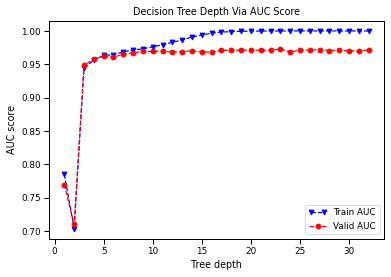

In [28]:
# to see if we need to alter max depth
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
valid_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   valid_pred = dt.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   valid_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'bv--', label= "Train AUC")
line2, = plt.plot(max_depths, valid_results, 'ro--', label="Valid AUC")
plt.title('Decision Tree Depth Via AUC Score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

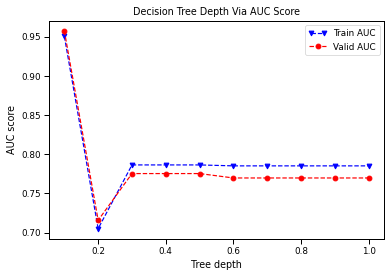

In [29]:
# to see if we should alter min sample split
# min_samples_split is the min. # of samples required to split an internal node

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
valid_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_splits, train_results, 'bv--', label= "Train AUC")
line2, = plt.plot(min_samples_splits, valid_results, 'ro--', label="Valid AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Decision Tree Depth Via AUC Score')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

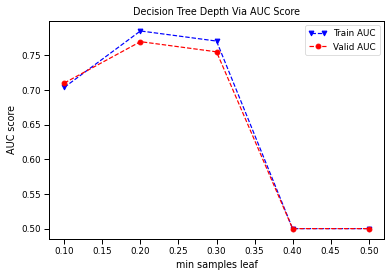

In [30]:
# min_samples_leaf: min # of samples to be a leaf

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
valid_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'bv--', label= "Train AUC")
line2, = plt.plot(min_samples_leafs, valid_results, 'ro--', label="Valid AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Decision Tree Depth Via AUC Score')
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Depth =  3 	 Valid Accuracy = 0.96 	     Training Accuracy = 0.95
Depth =  4 	 Valid Accuracy = 0.97 	     Training Accuracy = 0.97
Depth =  5 	 Valid Accuracy = 0.97 	     Training Accuracy = 0.98
Depth =  6 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.98
Depth =  7 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.98
Depth =  8 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.99
Depth =  9 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.99
Depth = 10 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.99
Depth = 11 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.99
Depth = 12 	 Valid Accuracy = 0.98 	     Training Accuracy = 0.99
Depth = 13 	 Valid Accuracy = 0.97 	     Training Accuracy = 0.99
Depth = 14 	 Valid Accuracy = 0.98 	     Training Accuracy = 1.00


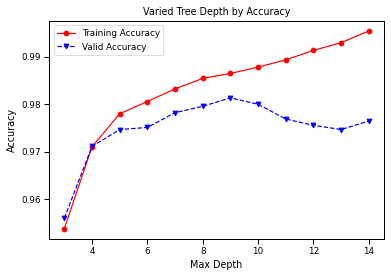

In [31]:
accuracy_depth = []

# Vary the decision tree depth in a loop, increasing depth from 3 to 14. 
for depth in range(3,15):
    varied_tree  = DecisionTreeClassifier(max_depth=depth, random_state=42)
    varied_tree  = varied_tree.fit(X_train,y_train)
    tree_valid_pred = varied_tree.predict(X_valid)
    tree_train_pred = varied_tree.predict(X_train)
    accuracy_depth.append({'depth':depth,
                           'valid_accuracy':accuracy_score(y_valid,tree_valid_pred),
                           'train_accuracy':accuracy_score(y_train,tree_train_pred)})
    print('Depth = %2.0f \t Valid Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (depth,accuracy_score(y_valid, tree_valid_pred),
                                 accuracy_score(y_train, tree_train_pred)))

abd_df = pd.DataFrame(accuracy_depth)
abd_df.index = abd_df['depth']

fig, ax=plt.subplots()

ax.plot(abd_df.depth,abd_df.train_accuracy,'ro-',label='Training Accuracy')
ax.plot(abd_df.depth,abd_df.valid_accuracy,'bv--',label='Valid Accuracy')
plt.title('Varied Tree Depth by Accuracy')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Untuned Decision Tree Classifier
untuned_hr_tree = DecisionTreeClassifier(random_state=42)
untuned_hr_tree = untuned_hr_tree.fit(X_train, y_train)

# Predict on validation set
untuned_hr_tree1 = untuned_hr_tree.predict(X_valid)
# Predict on test set
untuned_hr_tree2 = untuned_hr_tree.predict(X_test)

# accuracy and classification report
print('Untuned Decision Tree Classifier')
print('Accuracy Score')
print(accuracy_score(y_valid, untuned_hr_tree1))
print('Classification Report \n', 
      classification_report(y_valid, untuned_hr_tree1))

# Tuned Decision Tree Classifier
accuracy_depth = []
for depth in range(3,11):
    hr_tree = DecisionTreeClassifier(criterion='entropy',
                                     max_depth=13,
                                     random_state=42,
                                     class_weight='balanced')
    hr_tree = hr_tree.fit(X_train, y_train)

    # Predict on validation set
    hr_tree_valid = hr_tree.predict(X_valid)
    # Predict on test set
    hr_tree_test = hr_tree.predict(X_test)

# accuracy and classification report
print('Tuned Decision Tree Classifier')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_tree_valid))
print('Classification Report \n', 
      classification_report(y_valid, hr_tree_valid))

Untuned Decision Tree Classifier
Accuracy Score
0.9711111111111111
Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1716
           1       0.92      0.97      0.94       534

    accuracy                           0.97      2250
   macro avg       0.95      0.97      0.96      2250
weighted avg       0.97      0.97      0.97      2250

Tuned Decision Tree Classifier
Accuracy Score
0.9693333333333334
Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1716
           1       0.92      0.95      0.94       534

    accuracy                           0.97      2250
   macro avg       0.95      0.96      0.96      2250
weighted avg       0.97      0.97      0.97      2250



A pruned Decision Tree Classifier for this dataset is depicted below:

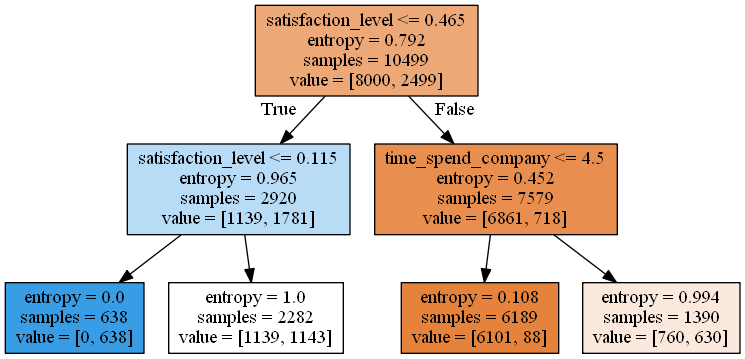

In [33]:
# Plot the decision tree with a smaller max depth of 2
hr_tree2 = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=2,
                                  random_state=42)
hr_tree2 = hr_tree2.fit(X_train,y_train)
hr_tree2_pred2 = hr_tree2.predict(X_valid)

dot_data = export_graphviz(hr_tree2,
feature_names = X_var,
filled = True, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Support Vector Machines - Linear Kernel

In [67]:
# Semi-tuned Support Vector Machine
hr_svm = SVC(kernel = "linear", random_state=42, 
probability=True)
hr_svm.fit(X_train, y_train)
hr_svm_pred_valid = hr_svm.predict(X_valid)
hr_svm_pred_test = hr_svm.predict(X_test)

# accuracy and classification report
print('Semi-tuned Support Vector Machine')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_svm_pred_valid))
print('Classification Report \n', 
       classification_report(y_valid, hr_svm_pred_valid))

Semi-tuned Support Vector Machine
Accuracy Score
0.7706666666666667
Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      1716
           1       0.54      0.24      0.34       534

    accuracy                           0.77      2250
   macro avg       0.67      0.59      0.60      2250
weighted avg       0.74      0.77      0.74      2250



### Support Vector Machines - Radial Basis Function Kernel

Cost = 0.01 	 Valid Accuracy = 0.76 	     Training Accuracy = 0.76
Cost = 0.10 	 Valid Accuracy = 0.91 	     Training Accuracy = 0.92
Cost = 0.20 	 Valid Accuracy = 0.93 	     Training Accuracy = 0.94
Cost = 0.50 	 Valid Accuracy = 0.95 	     Training Accuracy = 0.96
Cost = 0.80 	 Valid Accuracy = 0.95 	     Training Accuracy = 0.96
Cost = 1.00 	 Valid Accuracy = 0.95 	     Training Accuracy = 0.96
Cost = 5.00 	 Valid Accuracy = 0.96 	     Training Accuracy = 0.98
Cost = 10.00 	 Valid Accuracy = 0.96 	     Training Accuracy = 0.99
Cost = 20.00 	 Valid Accuracy = 0.96 	     Training Accuracy = 0.99
Cost = 50.00 	 Valid Accuracy = 0.96 	     Training Accuracy = 1.00


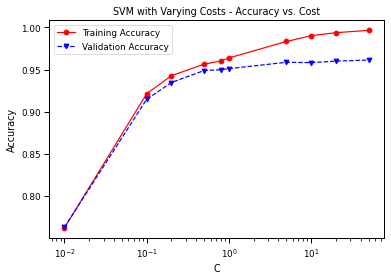

Tuned Support Vector Machine
Accuracy Score
0.9613333333333334
Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1716
           1       0.90      0.94      0.92       534

    accuracy                           0.96      2250
   macro avg       0.94      0.95      0.95      2250
weighted avg       0.96      0.96      0.96      2250



In [35]:
# Tuned Support Vector Machine
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]

hr_svm1_trainAcc = []
hr_svm1_validAcc = []
hr_svm1_testAcc = []

for param in C:
    hr_svm1 = SVC(C=param, kernel='rbf', 
                  gamma = 'auto', random_state=42,
                  probability=True)
    hr_svm1.fit(X_train, y_train)
    hr_svm1_pred_train = hr_svm1.predict(X_train)
    hr_svm1_pred_valid = hr_svm1.predict(X_valid)
    hr_svm1_pred_test = hr_svm1.predict(X_test)  
    hr_svm1_trainAcc.append(accuracy_score(y_train, hr_svm1_pred_train))
    hr_svm1_validAcc.append(accuracy_score(y_valid, hr_svm1_pred_valid))
    print('Cost = %2.2f \t Valid Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (param, accuracy_score(y_valid,
                                 hr_svm1_pred_valid),
                                 accuracy_score(y_train ,
                                 hr_svm1_pred_train)))    

fig, ax = plt.subplots()
ax.plot(C, hr_svm1_trainAcc, 'ro-', C, hr_svm1_validAcc,'bv--')
ax.legend(['Training Accuracy','Validation Accuracy'])
plt.title('SVM with Varying Costs - Accuracy vs. Cost')
ax.set_xlabel('C')
ax.set_xscale('log')
ax.set_ylabel('Accuracy')
plt.show()

# accuracy and classification report
print('Tuned Support Vector Machine')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_svm1_pred_valid))
print('Classification Report \n', 
       classification_report(y_valid, hr_svm1_pred_valid))

### Random Forests

Untuned Random Forest Model
Accuracy Score
0.9893333333333333
Classification Report 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1716
           1       0.99      0.96      0.98       534

    accuracy                           0.99      2250
   macro avg       0.99      0.98      0.99      2250
weighted avg       0.99      0.99      0.99      2250

Max Depth =  1 	 validing Accuracy = 0.76 	     Training Accuracy = 0.76
Max Depth =  2 	 validing Accuracy = 0.91 	     Training Accuracy = 0.91
Max Depth =  3 	 validing Accuracy = 0.91 	     Training Accuracy = 0.92
Max Depth =  4 	 validing Accuracy = 0.95 	     Training Accuracy = 0.96
Max Depth =  5 	 validing Accuracy = 0.97 	     Training Accuracy = 0.98
Max Depth =  6 	 validing Accuracy = 0.98 	     Training Accuracy = 0.98
Max Depth =  7 	 validing Accuracy = 0.98 	     Training Accuracy = 0.98
Max Depth =  8 	 validing Accuracy = 0.98 	     Training Accuracy = 0.98
Max

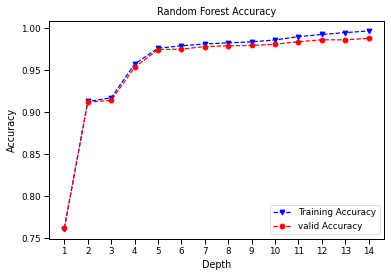

Tuned Random Forest Model
Accuracy Score
0.9871111111111112
Classification Report 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1716
           1       0.99      0.96      0.97       534

    accuracy                           0.99      2250
   macro avg       0.99      0.98      0.98      2250
weighted avg       0.99      0.99      0.99      2250



In [36]:
# Untuned Random Forest
hr_rf = RandomForestClassifier(random_state=42)
hr_rf = hr_rf.fit(X_train, y_train)

# Predict on validation set
hr_rf1 = hr_rf.predict(X_valid)
# Predict on test set
hr_rf2 = hr_rf.predict(X_test)

# accuracy and classification report
print('Untuned Random Forest Model')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_rf1))
print('Classification Report \n', 
       classification_report(y_valid, hr_rf1))

# Random Forest Tuning
rf_train_accuracy = []
rf_valid_accuracy = []
for n in range(1, 15):
    rf = RandomForestClassifier(max_depth = n, random_state=42)
    rf = rf.fit(X_train,y_train)
    rf_pred_train = rf.predict(X_train)
    rf_pred_valid = rf.predict(X_valid)
    rf_train_accuracy.append(accuracy_score(y_train, rf_pred_train))
    rf_valid_accuracy.append(accuracy_score(y_valid, rf_pred_valid))
    print('Max Depth = %2.0f \t validing Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (n,accuracy_score(y_valid,rf_pred_valid),
                               accuracy_score(y_train,rf_pred_train)))
max_depth = list(range(1, 15))
plt.plot(max_depth, rf_train_accuracy, 'bv--', label='Training Accuracy')
plt.plot(max_depth, rf_valid_accuracy, 'ro--', label='valid Accuracy')
plt.title('Random Forest Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth)
plt.legend()
plt.show()

# Tuned Random Forest
hr_rf1_train_accuracy = []
hr_rf1_valid_accuracy = []
hr_rf1_test_accuracy = []
for n in range(1, 15):
    hr_rf1 = RandomForestClassifier(max_depth = 13,
                                    # max_features ='auto',
                                    n_estimators=50,
                                    random_state=42,  
                                    class_weight="balanced")
    hr_rf1 = hr_rf1.fit(X_train, y_train)
    hr_rf1_pred_train = hr_rf1.predict(X_train)
    hr_rf1_pred_valid = hr_rf1.predict(X_valid)
    hr_rf1_pred_test = hr_rf1.predict(X_test)

# accuracy and classification report
print('Tuned Random Forest Model')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_rf1_pred_valid))
print('Classification Report \n', 
      classification_report(y_valid, hr_rf1_pred_valid))

### Bagging

In [37]:
hr_bag = BaggingClassifier(base_estimator=\
                           KNeighborsClassifier(),
                           random_state=42)
hr_bag = hr_bag.fit(X_train, y_train)

# Predict on validation set
hr_bag_valid = hr_bag.predict(X_valid)
# Predict on test set
hr_bag_test = hr_bag.predict(X_test)

# accuracy and classification report
print('Bagging Model')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_bag_valid))
print('Classification Report \n', 
       classification_report(y_valid, hr_bag_valid))

Bagging Model
Accuracy Score
0.9342222222222222
Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      1716
           1       0.82      0.92      0.87       534

    accuracy                           0.93      2250
   macro avg       0.90      0.93      0.91      2250
weighted avg       0.94      0.93      0.94      2250



### Linear Discriminant Analysis 

Linear Discriminant Analysis uses the singular value decomposition (*svd*) solver by default. In this particular case, changing the solver hyperparameter to reflect eigenvalue decomposition (*eigen*) bears no significance to the performance metrics outcome. Neither does adjusting the shrinkage to *auto*, or storing the covriance matrix within the model. The results are still the same.

In [38]:
# Untuned Linear Discriminant Analysis
hr_lda = LinearDiscriminantAnalysis()
hr_lda = hr_lda.fit(X_train, y_train)

# Predict on validation set
hr_lda_valid = hr_lda.predict(X_valid)
# Predict on test set
hr_lda_test = hr_lda.predict(X_test)

# accuracy and classification report
print('Untuned LDA Model')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_lda_valid))
print('Classification Report \n', 
      classification_report(y_valid, hr_lda_valid))


# Tuned Linear Discriminant Analysis
hr_lda_tuned = LinearDiscriminantAnalysis(solver='eigen',
                                          shrinkage='auto',
                                          store_covariance = True)
hr_lda_tuned = hr_lda_tuned.fit(X_train, y_train)

# Predict on validation set
hr_lda_tuned_valid = hr_lda.predict(X_valid)
# Predict on test set
hr_lda_tuned_test = hr_lda.predict(X_test)

# accuracy and classification report
print('Tuned LDA Model')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_lda_tuned_valid))
print('Classification Report \n', 
      classification_report(y_valid, hr_lda_tuned_valid))


Untuned LDA Model
Accuracy Score
0.7711111111111111
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1716
           1       0.53      0.31      0.39       534

    accuracy                           0.77      2250
   macro avg       0.67      0.61      0.62      2250
weighted avg       0.74      0.77      0.75      2250

Tuned LDA Model
Accuracy Score
0.7711111111111111
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1716
           1       0.53      0.31      0.39       534

    accuracy                           0.77      2250
   macro avg       0.67      0.61      0.62      2250
weighted avg       0.74      0.77      0.75      2250



In [39]:
# Untuned Neural Network

hr_neural = MLPClassifier(random_state=42)

hr_neural.fit(X_train, y_train)

# Predict on validation set
hr_neural_pred = hr_neural.predict(X_valid)

# accuracy and classification report
print('Untuned Neural Network')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_neural_pred))
print('Classification Report \n', 
      classification_report(y_valid, hr_neural_pred))


# Tuned Neural Network

hr_neural1 = MLPClassifier(hidden_layer_sizes = (3), 
activation = 'logistic', solver = 'lbfgs', 
random_state=42, max_iter = 5000)

hr_neural1.fit(X_train,y_train)

# Predict on validation set
hr_neural_pred_valid = hr_neural1.predict(X_valid)
# Predict on test set
hr_neural_pred_test = hr_neural1.predict(X_test)

# accuracy and classification report
print('Tuned Neural Network')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_neural_pred_valid))
print('Classification Report \n', 
       classification_report(y_valid, hr_neural_pred_valid))


Untuned Neural Network
Accuracy Score
0.884
Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.86      0.92      1716
           1       0.68      0.95      0.80       534

    accuracy                           0.88      2250
   macro avg       0.83      0.91      0.86      2250
weighted avg       0.91      0.88      0.89      2250

Tuned Neural Network
Accuracy Score
0.7626666666666667
Classification Report 
               precision    recall  f1-score   support

           0       0.76      1.00      0.87      1716
           1       0.00      0.00      0.00       534

    accuracy                           0.76      2250
   macro avg       0.38      0.50      0.43      2250
weighted avg       0.58      0.76      0.66      2250



### *K*-Nearest Neighbors

In [40]:
results = []

for k in range (70, 80):
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train.values)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_valid, knn.predict(X_valid))
    })

results = pd.DataFrame(results)
print(results)

    k  accuracy
0  70      0.89
1  71      0.89
2  72      0.89
3  73      0.89
4  74      0.89
5  75      0.90
6  76      0.89
7  77      0.89
8  78      0.89
9  79      0.89


In [41]:
results = []
for k in range (1, 10):
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train.values)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_valid, knn.predict(X_valid))
    })

results = pd.DataFrame(results)
print(results)

   k  accuracy
0  1      0.95
1  2      0.94
2  3      0.93
3  4      0.94
4  5      0.93
5  6      0.94
6  7      0.93
7  8      0.93
8  9      0.93


# of Neighbors = 1 	 Validation Accuracy = 0.95 	         Training Accuracy = 1.00
# of Neighbors = 3 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.97
# of Neighbors = 5 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.95
# of Neighbors = 7 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.95
# of Neighbors = 9 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.94
# of Neighbors = 11 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.94
# of Neighbors = 13 	 Validation Accuracy = 0.92 	         Training Accuracy = 0.94
# of Neighbors = 15 	 Validation Accuracy = 0.92 	         Training Accuracy = 0.93
# of Neighbors = 17 	 Validation Accuracy = 0.92 	         Training Accuracy = 0.93
# of Neighbors = 19 	 Validation Accuracy = 0.92 	         Training Accuracy = 0.93


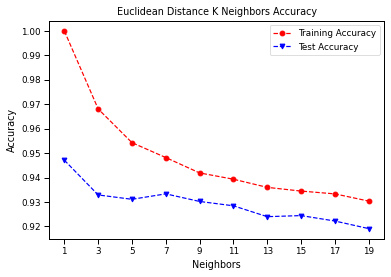

In [42]:
# euclidean distance
knn_train_accuracy = []
knn_valid_accuracy = []
knn_test_accuracy = []
for n in range(1, 20) :
    if(n%2!=0):
        knn = KNeighborsClassifier(n_neighbors = n, p = 2)
        knn = knn.fit(X_train,y_train)
        knn_pred_train = knn.predict(X_train)
        knn_pred_valid = knn.predict(X_valid)
        knn_pred_test = knn.predict(X_test)
        knn_train_accuracy.append(accuracy_score(y_train, knn_pred_train))
        knn_valid_accuracy.append(accuracy_score(y_valid, knn_pred_valid))
        knn_test_accuracy.append(accuracy_score(y_test, knn_pred_test))
        print('# of Neighbors = %d \t Validation Accuracy = %2.2f \t \
        Training Accuracy = %2.2f'% (n, accuracy_score(y_valid,knn_pred_valid),
                               accuracy_score(y_train,knn_pred_train)))
    
max_depth = list([1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
plt.plot(max_depth, knn_train_accuracy, 'ro--', label='Training Accuracy')
plt.plot(max_depth, knn_valid_accuracy, 'bv--', label='Test Accuracy')
plt.title('Euclidean Distance K Neighbors Accuracy')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.xticks(max_depth)
plt.legend()
plt.show()

# of Neighbors = 1 	 Validation Accuracy = 0.95 	         Training Accuracy = 1.00
# of Neighbors = 3 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.97
# of Neighbors = 5 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.96
# of Neighbors = 7 	 Validation Accuracy = 0.94 	         Training Accuracy = 0.95
# of Neighbors = 9 	 Validation Accuracy = 0.94 	         Training Accuracy = 0.95
# of Neighbors = 11 	 Validation Accuracy = 0.94 	         Training Accuracy = 0.95
# of Neighbors = 13 	 Validation Accuracy = 0.94 	         Training Accuracy = 0.94
# of Neighbors = 15 	 Validation Accuracy = 0.94 	         Training Accuracy = 0.94
# of Neighbors = 17 	 Validation Accuracy = 0.94 	         Training Accuracy = 0.94
# of Neighbors = 19 	 Validation Accuracy = 0.93 	         Training Accuracy = 0.94


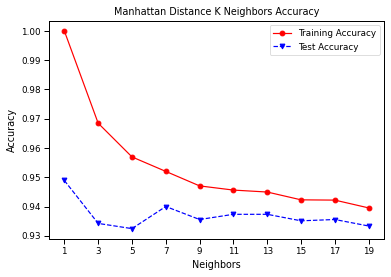

In [43]:
# Manhattan Distance
knn_train_accuracy = []
knn_valid_accuracy = []
knn_test_accuracy = []
for n in range(1, 20) :
    if(n%2!=0):
        knn = KNeighborsClassifier(n_neighbors = n, metric = 'manhattan', p = 1)
        knn = knn.fit(X_train,y_train)
        knn_pred_train = knn.predict(X_train)
        knn_pred_valid = knn.predict(X_valid)
        knn_pred_test = knn.predict(X_test)
        knn_train_accuracy.append(accuracy_score(y_train, knn_pred_train))
        knn_valid_accuracy.append(accuracy_score(y_valid, knn_pred_valid))
        knn_test_accuracy.append(accuracy_score(y_test, knn_pred_test))
        print('# of Neighbors = %d \t Validation Accuracy = %2.2f \t \
        Training Accuracy = %2.2f'% (n, accuracy_score(y_valid,knn_pred_valid),
                               accuracy_score(y_train,knn_pred_train)))
    
max_depth = list([1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
plt.plot(max_depth, knn_train_accuracy, 'ro-', label='Training Accuracy')
plt.plot(max_depth, knn_valid_accuracy, 'bv--', label='Test Accuracy')
plt.title('Manhattan Distance K Neighbors Accuracy')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.xticks(max_depth)
plt.legend()
plt.show()

In [44]:
hr_knn = KNeighborsClassifier(n_neighbors = 77, 
metric = 'manhattan', p = 1)
hr_knn = knn.fit(X_train,y_train)

# Predict on validation set
hr_knn_pred_valid = hr_knn.predict(X_valid)
# Predict on test set
hr_knn_pred_train = hr_knn.predict(X_test)
# accuracy and classification report
print('Tuned KNN Model (Manhattan Distance)')
print('Accuracy Score')
print(accuracy_score(y_valid, hr_knn_pred_valid))
print('Classification Report \n', 
      classification_report(y_valid, hr_knn_pred_valid))


Tuned KNN Model (Manhattan Distance)
Accuracy Score
0.9333333333333333
Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      1716
           1       0.83      0.91      0.87       534

    accuracy                           0.93      2250
   macro avg       0.90      0.92      0.91      2250
weighted avg       0.94      0.93      0.93      2250



### Model Evaluation

Confusion Matrices


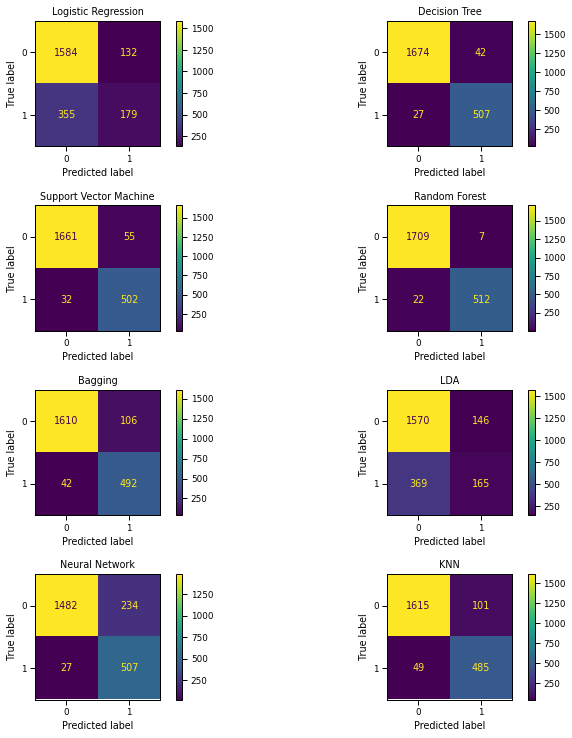

In [45]:
print("\033[1m"+'Confusion Matrices'+"\033[1m")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
flat = axes.flatten()
fig.tight_layout(w_pad=0.5, h_pad=4)

plot_confusion_matrix(tlr, X_valid, y_valid, ax=flat[0])
flat[0].set_title('Logistic Regression')

plot_confusion_matrix(hr_tree, X_valid, y_valid, ax=flat[1])
flat[1].set_title('Decision Tree')

plot_confusion_matrix(hr_svm1, X_valid, y_valid, ax=flat[2])
flat[2].set_title('Support Vector Machine')

plot_confusion_matrix(hr_rf1, X_valid, y_valid, ax=flat[3])
flat[3].set_title('Random Forest')

plot_confusion_matrix(hr_bag, X_valid, y_valid, ax=flat[4])
flat[4].set_title('Bagging')

plot_confusion_matrix(hr_lda, X_valid, y_valid, ax=flat[5])
flat[5].set_title('LDA')

plot_confusion_matrix(hr_neural, X_valid, y_valid, ax=flat[6])
flat[6].set_title('Neural Network')

plot_confusion_matrix(hr_knn, X_valid, y_valid, ax=flat[7])
flat[7].set_title('KNN'); plt.show()

### Individual Cumulative Gains Charts 

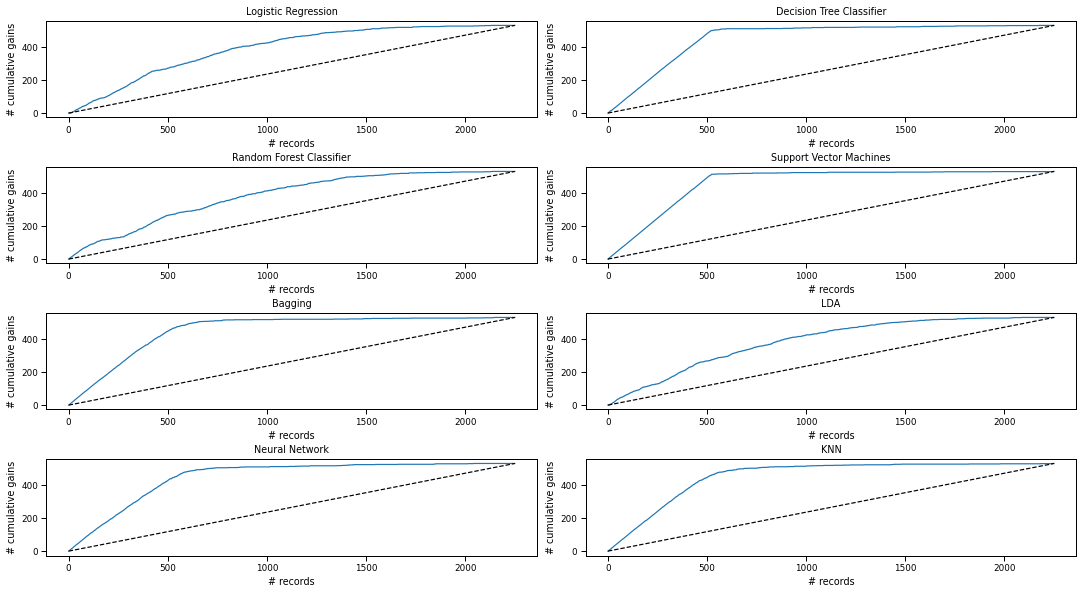

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,8))
flat = axes.flatten(); fig.tight_layout(w_pad=2, h_pad=3)
res_1 = pd.DataFrame({
    'actual': y_valid,
    'prob': tlr.predict_proba(X_valid[X_var])[:, 1]
})
res_1 = res_1.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_1.actual, ax=flat[0])
flat[0].set_title('Logistic Regression')

res_2 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_tree.predict_proba(X_valid[X_var])[:, 1]
})
res_2 = res_2.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_2.actual, ax=flat[1])
flat[1].set_title('Decision Tree Classifier')

res_3 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_svm.predict_proba(X_valid[X_var])[:, 1]
})
res_3 = res_3.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_3.actual, ax=flat[2])
flat[2].set_title('Random Forest Classifier')

res_4 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_rf1.predict_proba(X_valid[X_var])[:, 1]
})
res_4 = res_4.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_4.actual, ax=flat[3])
flat[3].set_title('Support Vector Machines') 

res_5 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_bag.predict_proba(X_valid[X_var])[:, 1]
})
res_5 = res_5.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_5.actual, ax=flat[4])
flat[4].set_title('Bagging') 

res_6 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_lda.predict_proba(X_valid[X_var])[:, 1]
})
res_6 = res_6.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_6.actual, ax=flat[5])
flat[5].set_title('LDA') 

res_7 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_neural.predict_proba(X_valid[X_var])[:, 1]
})
res_7 = res_7.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_7.actual, ax=flat[6])
flat[6].set_title('Neural Network') 

res_8 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_knn.predict_proba(X_valid[X_var])[:, 1]
})
res_8 = res_8.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
gainsChart(res_8.actual, ax=flat[7])
flat[7].set_title('KNN') 

plt.show()

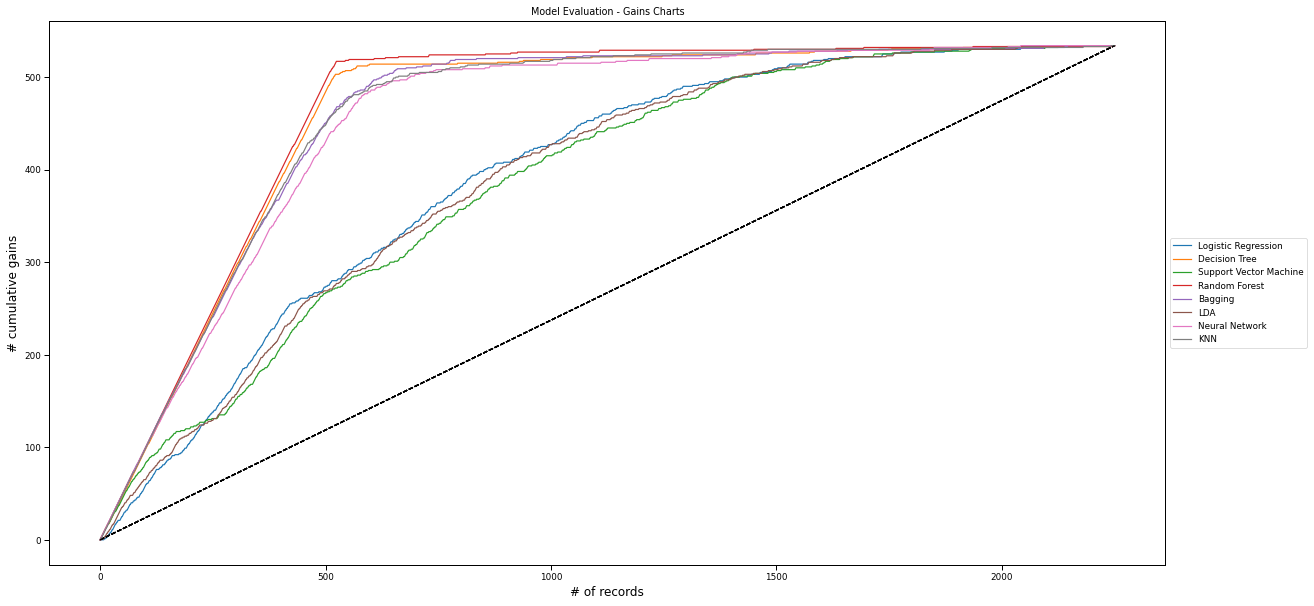

In [71]:
res_1 = pd.DataFrame({
    'actual': y_valid,
    'prob': tlr.predict_proba(X_valid[X_var])[:, 1]
})
res_1 = res_1.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_2 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_tree.predict_proba(X_valid[X_var])[:, 1]
})
res_2 = res_2.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_3 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_svm.predict_proba(X_valid[X_var])[:, 1]
})
res_3 = res_3.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_4 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_rf1.predict_proba(X_valid[X_var])[:, 1]
})
res_4 = res_4.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_5 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_bag.predict_proba(X_valid[X_var])[:, 1]
})
res_5 = res_5.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_6 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_lda.predict_proba(X_valid[X_var])[:, 1]
})
res_6 = res_6.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_7 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_neural.predict_proba(X_valid[X_var])[:, 1]
})
res_7 = res_7.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

res_8 = pd.DataFrame({
    'actual': y_valid,
    'prob': hr_knn.predict_proba(X_valid[X_var])[:, 1]
})
res_8 = res_8.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

ax=gainsChart(res_1.actual, label='Logistic Regression', color='C0', figsize=[20,10])
ax=gainsChart(res_2.actual, label='Decision Tree', color='C1', ax=ax)
ax=gainsChart(res_3.actual, label='Support Vector Machine', color='C2', ax=ax)
ax=gainsChart(res_4.actual, label='Random Forest', color='C3', ax=ax)
ax=gainsChart(res_5.actual, label='Bagging', color='C4', ax=ax)
ax=gainsChart(res_6.actual, label='LDA', color='C5', ax=ax)
ax=gainsChart(res_7.actual, label='Neural Network', color='C6', ax=ax)
ax=gainsChart(res_8.actual, label='KNN', color='C7', ax=ax)
plt.title('Model Evaluation - Gains Charts')
plt.xlabel('# of records', fontsize=12) 
plt.ylabel('# cumulative gains', fontsize=12) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### ROC Curves

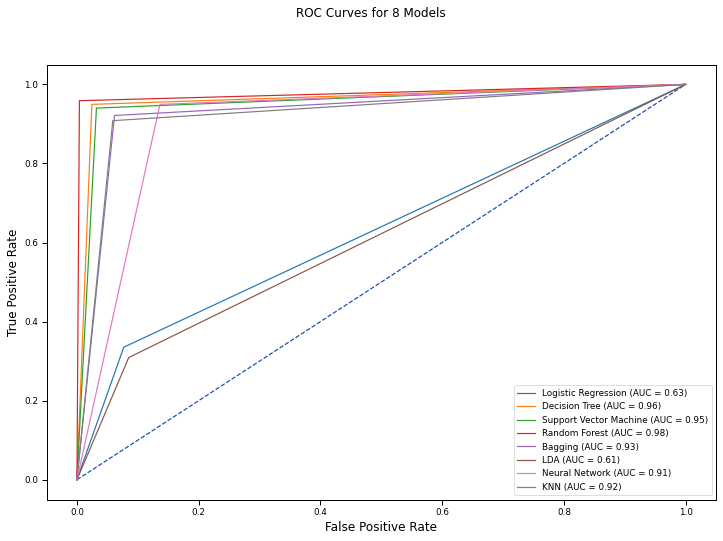

In [74]:
tlr_roc = metrics.roc_curve(y_valid, tlr_pred_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, tlr_pred_valid)
tlr_auc = metrics.auc(fpr, tpr)
tlr_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=tlr_auc, 
estimator_name='Logistic Regression')

hr_tree_roc = metrics.roc_curve(y_valid, hr_tree_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_tree_valid)
hr_tree_auc = metrics.auc(fpr, tpr)
hr_tree_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,
roc_auc=hr_tree_auc , 
estimator_name='Decision Tree')

hr_svm_roc = metrics.roc_curve(y_valid, hr_svm_pred_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_svm_pred_valid)
hr_svm_auc = metrics.auc(fpr, tpr)
hr_svm_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=hr_svm_auc, 
estimator_name='Support Vector Machine')

hr_rf1_roc = metrics.roc_curve(y_valid, hr_rf1_pred_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_rf1_pred_valid)
hr_rf1_auc = metrics.auc(fpr, tpr)
hr_rf1_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=hr_rf1_auc, 
estimator_name='Random Forest')

hr_bag_valid_roc = metrics.roc_curve(y_valid, hr_bag_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_bag_valid)
hr_bag_valid_auc = metrics.auc(fpr, tpr)
hr_bag_valid_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=hr_bag_valid_auc, 
estimator_name='Bagging')

hr_lda_tuned_roc = metrics.roc_curve(y_valid, hr_lda_tuned_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_lda_tuned_valid)
hr_lda_tuned_auc = metrics.auc(fpr, tpr)
hr_lda_tuned_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=hr_lda_tuned_auc, 
estimator_name='LDA')

hr_neural_roc = metrics.roc_curve(y_valid, hr_neural_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_neural_pred)
hr_neural_auc = metrics.auc(fpr, tpr)
hr_neural_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=hr_neural_auc, 
estimator_name='Neural Network')

hr_knn_roc = metrics.roc_curve(y_valid, hr_knn_pred_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, hr_knn_pred_valid)
hr_knn_auc = metrics.auc(fpr, tpr)
hr_knn_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, 
roc_auc=hr_knn_auc, 
estimator_name='KNN')

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle('ROC Curves for 8 Models', fontsize=12)
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.xlabel('',fontsize=12) 
plt.ylabel('',fontsize=12) 

# Model ROC Plots Defined above
tlr_plot.plot(ax)
hr_tree_plot.plot(ax)
hr_svm1_plot.plot(ax)
hr_rf1_plot.plot(ax)
hr_bag_valid_plot.plot(ax)
hr_lda_tuned_plot.plot(ax)
hr_neural_plot.plot(ax)
hr_knn_plot.plot(ax)
plt.show()

**Defining Model Performance Metrics for the validation set:**

In [75]:
# Logistic Regression Performance Metrics
report1 = classification_report(y_valid, tlr_pred_valid,
output_dict=True)
accuracy1 = round(report1['accuracy'],2)
precision1 = round(report1['1']['precision'],2)
recall1 = round(report1['1']['recall'],2)
fl_score1 = round(report1['1']['f1-score'],2)

# Decision Tree Performance Metrics                       
report2 = classification_report(y_valid, hr_tree_valid,
output_dict=True)
accuracy2 = round(report2['accuracy'],2)
precision2 = round(report2['1']['precision'],2)
recall2 = round(report2['1']['recall'],2)
fl_score2 = round(report2['1']['f1-score'],2)

# Support Vector Machine
report3 = classification_report(y_valid, hr_svm_pred_valid,
output_dict=True)                
accuracy3 = round(report3['accuracy'],2)
precision3 = round(report3['1']['precision'],2)
recall3 = round(report3['1']['recall'],2)
fl_score3 = round(report3['1']['f1-score'],2)

# Random Forest Performance Metrics
report4 = classification_report(y_valid, hr_rf1_pred_valid,
output_dict=True)                
accuracy4 = round(report4['accuracy'],2)
precision4 = round(report4['1']['precision'],2)
recall4 = round(report4['1']['recall'],2)
fl_score4 = round(report4['1']['f1-score'],2)             

# Bagging Performance Metrics
report5 = classification_report(y_valid, hr_bag_valid,
output_dict=True)           
accuracy5 = round(report5['accuracy'],2)
precision5 = round(report5['1']['precision'],2)
recall5 = round(report5['1']['recall'],2)
fl_score5 = round(report5['1']['f1-score'],2)

# LDA Performance Metrics
report6 = classification_report(y_valid, hr_lda_tuned_valid,
output_dict=True)           
accuracy6 = round(report6['accuracy'],2)
precision6 = round(report6['1']['precision'],2)
recall6 = round(report6['1']['recall'],2)
fl_score6 = round(report6['1']['f1-score'],2)

# Neural Network Performance Metrics
report7 = classification_report(y_valid, hr_neural_pred,
output_dict=True)           
accuracy7 = round(report7['accuracy'],2)
precision7 = round(report7['1']['precision'],2)
recall7 = round(report7['1']['recall'],2)
fl_score7 = round(report7['1']['f1-score'],2)

# Neural Network Performance Metrics
report8 = classification_report(y_valid, hr_knn_pred_valid,
output_dict=True)           
accuracy8 = round(report8['accuracy'],2)
precision8 = round(report8['1']['precision'],2)
recall8 = round(report8['1']['recall'],2)
fl_score8 = round(report8['1']['f1-score'],2)            

In [76]:
table1 = PrettyTable()
table1.field_names = ['Model', 'Valid. Accur.', 
                      'Precision', 'Recall', 'F1-score']
table1.add_row(['Logistic Regression', accuracy1, precision1, 
                recall1, fl_score1])
table1.add_row(['Decision Tree', accuracy2, precision2, 
                recall2, fl_score2])
table1.add_row(['Support Vector Machine', accuracy3, precision3, 
                recall3, fl_score3])
table1.add_row(['Random Forest', accuracy4, precision4, 
                recall4, fl_score4])
table1.add_row(['Bagging', accuracy5, precision5, 
                recall5, fl_score5])
table1.add_row(['LDA', accuracy6, precision6, 
                recall6, fl_score6])
table1.add_row(['Neural Network', accuracy7, precision7, 
                recall7, fl_score7])
table1.add_row(['K-Nearest Neighbor', accuracy8, precision8, 
recall8, fl_score8]); print(table1)

+------------------------+---------------+-----------+--------+----------+
|         Model          | Valid. Accur. | Precision | Recall | F1-score |
+------------------------+---------------+-----------+--------+----------+
|  Logistic Regression   |      0.78     |    0.58   |  0.34  |   0.42   |
|     Decision Tree      |      0.97     |    0.92   |  0.95  |   0.94   |
| Support Vector Machine |      0.77     |    0.54   |  0.24  |   0.34   |
|     Random Forest      |      0.99     |    0.99   |  0.96  |   0.97   |
|        Bagging         |      0.93     |    0.82   |  0.92  |   0.87   |
|          LDA           |      0.77     |    0.53   |  0.31  |   0.39   |
|     Neural Network     |      0.88     |    0.68   |  0.95  |   0.8    |
|   K-Nearest Neighbor   |      0.93     |    0.83   |  0.91  |   0.87   |
+------------------------+---------------+-----------+--------+----------+


In [78]:
# Mean-Squared Errors 
rmse0 = round(mean_squared_error(y_valid, tlr_pred_valid),2)
rmse1 = round(mean_squared_error(y_valid, hr_tree_valid),2)
rmse2 = round(mean_squared_error(y_valid, hr_svm_pred_valid),2)
rmse3 = round(mean_squared_error(y_valid, hr_rf1_pred_valid),2)
rmse4 = round(mean_squared_error(y_valid, hr_bag_valid),2)
rmse5 = round(mean_squared_error(y_valid, hr_lda_tuned_valid),2)
rmse6 = round(mean_squared_error(y_valid, hr_neural_pred_valid),2)
rmse7 = round(mean_squared_error(y_valid, hr_knn_pred_valid),2)

table2 = PrettyTable()
table2.field_names = ['Model', 'AUC', 'RMSE']
table2.add_row(['Logistic Regression', round(tlr_auc,2), rmse0])
table2.add_row(['Decision Tree', round(hr_tree_auc,2), rmse1])
table2.add_row(['Support Vector Machine', round(hr_svm_auc,2), rmse2])
table2.add_row(['Random Forest', round(hr_rf1_auc,2), rmse3])
table2.add_row(['Bagging', round(hr_bag_valid_auc,2), rmse4])
table2.add_row(['LDA', round(hr_lda_tuned_auc,2), rmse5])
table2.add_row(['Neural Network', round(hr_neural_auc,2), rmse6])
table2.add_row(['K-Nearest Neighbor', round(hr_knn_auc,2), rmse7])
print(table2)

+------------------------+------+------+
|         Model          | AUC  | RMSE |
+------------------------+------+------+
|  Logistic Regression   | 0.63 | 0.22 |
|     Decision Tree      | 0.96 | 0.03 |
| Support Vector Machine | 0.59 | 0.23 |
|     Random Forest      | 0.98 | 0.01 |
|        Bagging         | 0.93 | 0.07 |
|          LDA           | 0.61 | 0.23 |
|     Neural Network     | 0.91 | 0.24 |
|   K-Nearest Neighbor   | 0.92 | 0.07 |
+------------------------+------+------+


In [52]:
new_df = X_test.copy()

In [81]:
new_df['Probabilities'] = tlr.predict_proba(new_df[X_var])[:, 1]
new_df['Predictions'] = tlr.predict(new_df[X_var])
new_df.sort_values(by='Probabilities', ascending=False)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,department_label,salary_level,Probabilities,Predictions
11297,0.14,0.58,4,275,10,0,0,7,2,0.90,1
13508,0.14,0.58,4,275,10,0,0,7,2,0.90,1
11496,0.31,0.86,3,266,7,0,0,7,1,0.87,1
3559,0.15,0.52,4,265,6,0,0,8,1,0.86,1
13825,0.25,0.72,5,279,8,0,0,5,1,0.85,1
...,...,...,...,...,...,...,...,...,...,...,...
8887,0.99,0.54,4,196,4,1,0,3,3,0.00,0
10937,0.92,0.60,5,236,3,1,1,7,2,0.00,0
11107,0.87,0.60,5,165,2,1,0,5,3,0.00,0
4553,1.00,0.76,6,246,3,1,1,8,2,0.00,0


In [82]:
test = new_df.to_csv('test.csv')

In [55]:
future_prob1 = pd.DataFrame({'Probability': hr_knn.predict_proba(X_valid[X_var])[:, 1]})
future_prob1 

,Probability
0,0.05
1,0.00
2,0.00
3,0.11
4,0.00
...,...
2245,1.00
2246,0.95
2247,0.89
2248,0.00


**References**

Galarnyk, M. (2021, February 3). How to Speed up Scikit-Learn Model Training. *Anyscale.* https://www.anyscale.com/blog/how-to-speed-up-scikit-learn-model-training .